<a href="https://colab.research.google.com/github/MarkStephens060482/forecasting_BEV_adoption_LGA/blob/main/Uptake_of_Electric_Vehicles_Imputation_and_Variable_Selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Uptake of Electric Vehicles at LGA level - Single Imputation of Auxiliary Variables and Variable selection
### Enhancing Sustainable Transportation Planning through Explainable Electric Vehicle Adoption Forecasting in Ausrralian Local Governments.
Performed in Python language
1. Load Analysis and Auxiliary data sets
2. Further clean preprocess datasets
3. Select complete-case variables from Analysis dataset to include with Auxiliary variable dataset
4. Perform Single Imputation of near complete-case variables, ERP_P, INCOME and CABREE, in Auxiliary feature set, via simple quadratic and linear extrapolation and interpolation of timeseries.
5. Perform further Iterative round-robin Single Imputation of remaining variables via a Bayesian Ridge learner.

In [185]:
!pip install -U scikit-learn
!pip install panelsplit


### Imputation of Longgitudinal data
https://link.springer.com/article/10.1186/s12874-018-0615-6

https://onlinelibrary.wiley.com/doi/epdf/10.1002/sim.9225

https://www.tandfonline.com/doi/full/10.1080/10618600.2022.2149540

https://cran.r-project.org/web/packages/clusterMI/vignettes/clusterMI.html

https://arxiv.org/pdf/2404.06967


In [186]:
from sklearn.ensemble import RandomForestRegressor
# To use this experimental feature, we need to explicitly ask for it:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from google.colab import drive
import os
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import KNNImputer

from panelsplit import PanelSplit
from sklearn.metrics import mean_absolute_percentage_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
drive.mount('/content/drive')

#%load_ext cudf.pandas
# Set the working directory to a specific path
cwd = os.getcwd()
PATH = "/content/drive/MyDrive/Masters Data Science work/Masters of Data Science Study/Masters Program/Capstone Project"
os.chdir(PATH)

#silence warning
warnings.filterwarnings('ignore', category=RuntimeWarning)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Reading Analysis and Auxiliary variable dataset

In [187]:
dfs=[]
files = ['Auxiliary_df.csv','Analysis_df.csv']
for file in files:
  with open(file,encoding="utf-8") as dataFile:
        df = pd.read_csv(dataFile,index_col=False)
  dfs.append(df)
# Assign the dataframe with smaller number of variables the Analytical_df
if len(dfs[0].columns) < len(dfs[1].columns):
  # define Analytical Variables
  Analysis_df = dfs[0]
  #define charging
  Auxiliary_df = dfs[1]
else:
  # define Analytical Variables
  Analysis_df = dfs[1]
  #define charging
  Auxiliary_df = dfs[0]

## Simple impute Auxiliary Variables to achieve complete case
1. Impute ERP_P, INCOME and CABREE variables via linear and quadratic interpolation and extrapolation.
2. Checking for extreme value extrapolates on a quadratic model via comparison against 2 standard deviation from the mean and occurrences of negative values.
3. Further Imputation is performed via Iterative imputation via bayesian ridge learner

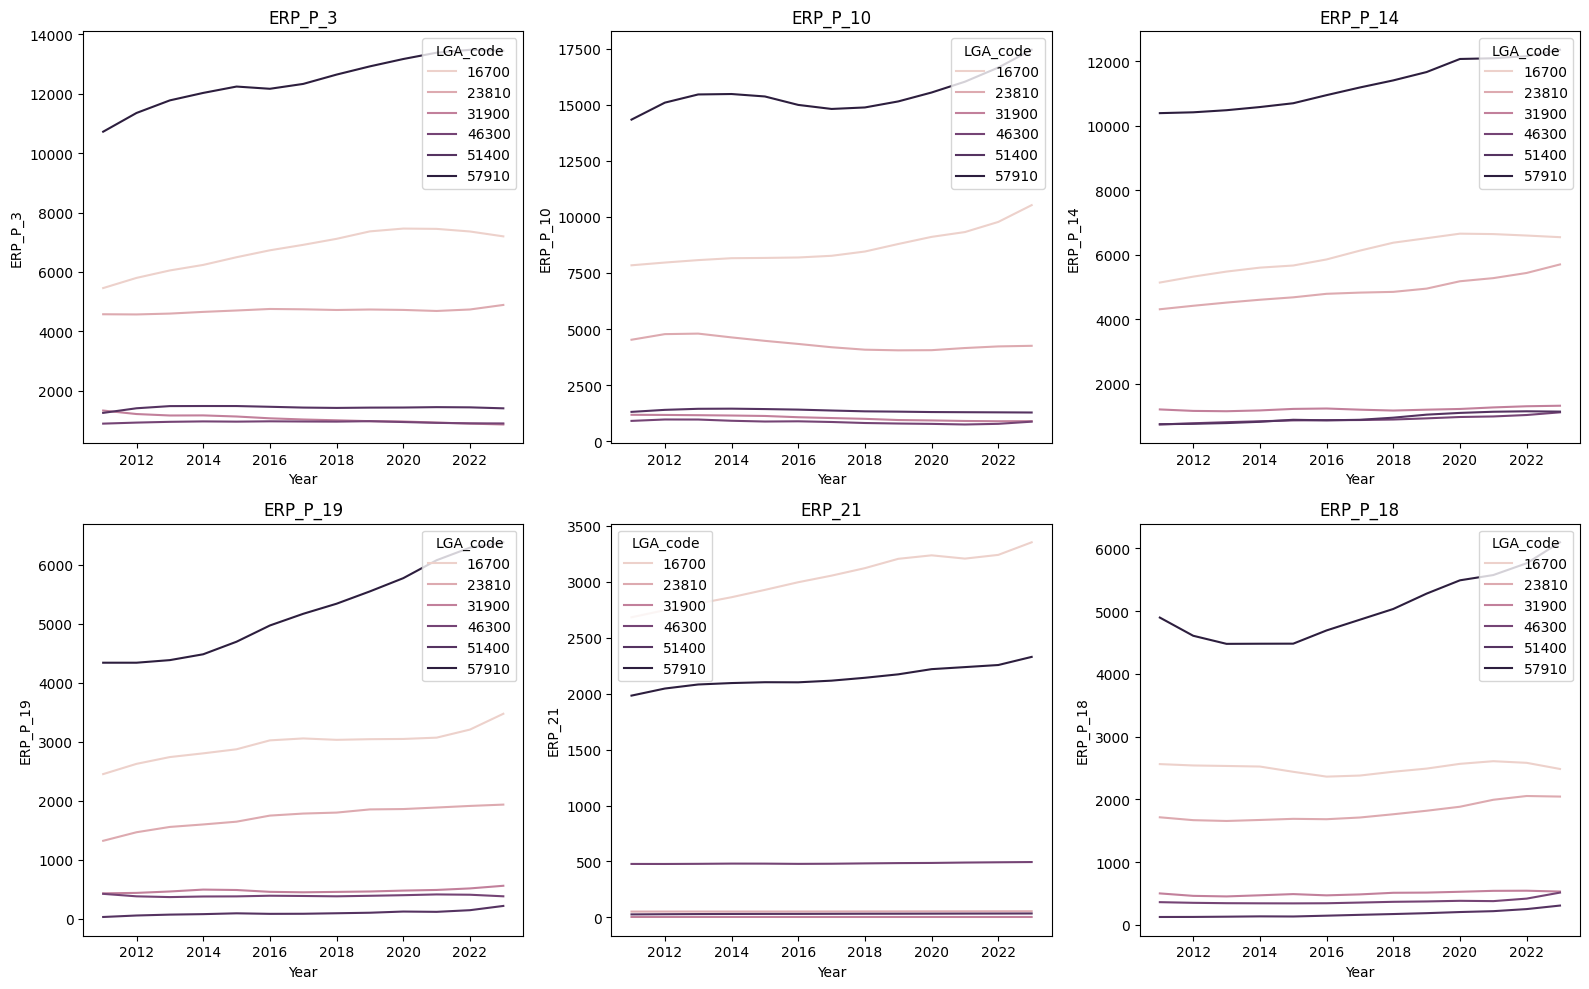

In [188]:
# drop columns with missing values
Analysis_complete_df = Analysis_df.dropna(axis = 1)
Analysis_complete_df = Analysis_complete_df.drop(columns = ['LGA_name','Distance_capital'])
# merge Analytical_complete_df and Auxiliary_df
impute_Auxiliary_df = Auxiliary_df.merge(Analysis_complete_df, on = ['Year','LGA_code'])
# Drop LGA_name
impute_Auxiliary_df = impute_Auxiliary_df.drop(columns = ['LGA_name'])
#set feature set as numeric values only
num_features = impute_Auxiliary_df.select_dtypes(include=['int64', 'float64']).columns

# get list of unique lga_code
unique_lgas = impute_Auxiliary_df['LGA_code'].unique()

##### Impute columns via interpolation
##### ERP_P columns
# Define the string to search for
fig,axs = plt.subplots(2,3,figsize = (16, 10))
axs = axs.flatten()
search_string = 'ERP'
count = 0
# Select columns that contain the given string
filtered_columns = list(impute_Auxiliary_df.filter(like = search_string).columns)
filtered_columns.extend(['LGA_code','Year'])
# interpolate the filtered_columns grouped by LGA_code
kw = dict(method="quadratic", fill_value="extrapolate", limit_direction="both")
for lga in unique_lgas:
  impute_Auxiliary_df.loc[impute_Auxiliary_df.LGA_code == lga,filtered_columns] = impute_Auxiliary_df.loc[impute_Auxiliary_df.LGA_code == lga,filtered_columns].transform(lambda x: x.interpolate(**kw))
#sample 5 from LGA_CODE
vars_sample = list(np.random.choice(filtered_columns[:-2],6,replace = False))
vars = vars_sample + ['LGA_code','Year']
lga_samp = list(np.random.choice(unique_lgas,6,replace = False))
plot_data = impute_Auxiliary_df.loc[impute_Auxiliary_df.LGA_code.isin(lga_samp),vars]
#filter for LGA_CODE
for var in vars_sample:
  sns.lineplot(plot_data, x = 'Year',y = var, hue = 'LGA_code', ax = axs[count] )
  axs[count].set_title(f'{var}')
  count += 1
plt.tight_layout()
plt.show()


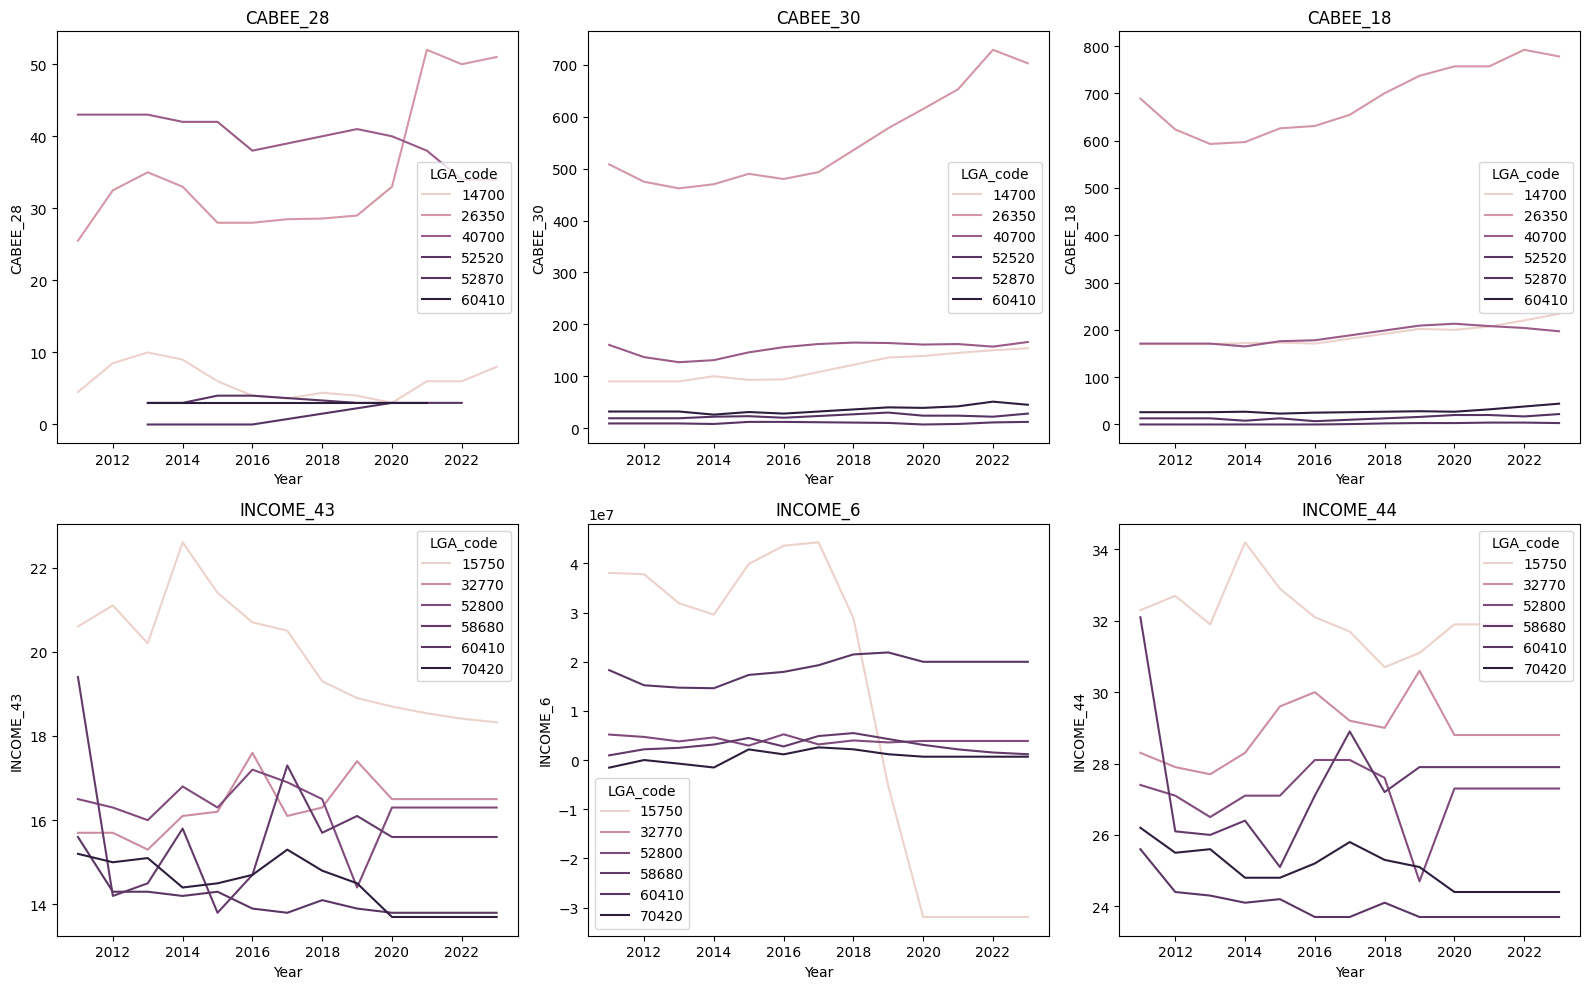

In [189]:
####  Impute INCOME and CABEE columns via interpolation and extrapolation
search_string = ['CABEE','INCOME']

# Define the string to search for
fig,axs = plt.subplots(2,3,figsize = (16, 10))
axs = axs.flatten()
count = 0
for string in search_string:
  # Select columns that contain the given string
  filtered_columns = list(impute_Auxiliary_df.filter(like = string).columns)
  kw = dict(method="quadratic", fill_value="extrapolate", limit_direction = "both")
  kw1 = dict(method="linear",  fill_value="extrapolate", limit_direction = "both")
  plot_lga = []
  for var in filtered_columns:
    # determine cluster means, groupby state, electoral rating and year
    # variable_cluster_means = impute_Auxiliary_df.groupby(['Official Name State','Electoral Rating','Year'])[var].count().reset_index()
    # lga missingness
    lga_missing = pd.DataFrame()
    lga_missing['missing_count'] = (impute_Auxiliary_df.groupby(['LGA_code'])['Year'].count() - impute_Auxiliary_df.groupby(['LGA_code'])[var].count())
    lga_missing = lga_missing.reset_index()
    lga_missing = lga_missing.sort_values(by = 'missing_count',ascending = False).reset_index(drop = True)
    # loop through lga_codes
    for lga in unique_lgas:
      # Proportion of missingness for each lga for the vartiable
      if lga_missing[lga_missing['LGA_code'] == lga]['missing_count'].values[0] <= 4:
        #add lga to plot_lga list if it is not already in list
        if lga not in plot_lga:
          plot_lga.append(lga)
        # impute missing values
        impute_series = impute_Auxiliary_df.loc[impute_Auxiliary_df.LGA_code == lga,var].transform(lambda x: x.interpolate(**kw))
        #if impute_series contains any negative value or a value is greater than or less than 1.5 standard deviation from the mean
        if impute_series[impute_series < 0].any() or (impute_series - impute_series.mean()).abs().max() > 2*impute_series.std():
          # impute missing values
          impute_series1 = impute_Auxiliary_df.loc[impute_Auxiliary_df.LGA_code == lga,var].transform(lambda x: x.interpolate(**kw1))
          impute_Auxiliary_df.loc[impute_Auxiliary_df.LGA_code == lga,var] = impute_series1
        else:
          impute_Auxiliary_df.loc[impute_Auxiliary_df.LGA_code == lga,var] = impute_series
  #sample 5 from LGA_CODE
  vars_sample = list(np.random.choice(filtered_columns,3,replace = False))
  vars = vars_sample + ['LGA_code','Year']
  lga_samp = list(np.random.choice(plot_lga,6,replace = False))
  plot_data = impute_Auxiliary_df.loc[impute_Auxiliary_df.LGA_code.isin(lga_samp),vars]
  #filter for LGA_CODE
  for v in vars_sample:
    sns.lineplot(plot_data, x = 'Year',y = v, hue = 'LGA_code', ax = axs[count] )
    axs[count].set_title(f'{v}')
    count += 1
plt.tight_layout()
plt.show()
impute_Auxiliary_df.to_csv('impute_Auxiliary_df.csv', index = False)

## Further Iterative Imputation
1. Iterative Round-Robin Single Imputation via Bayesian Ridge learner.

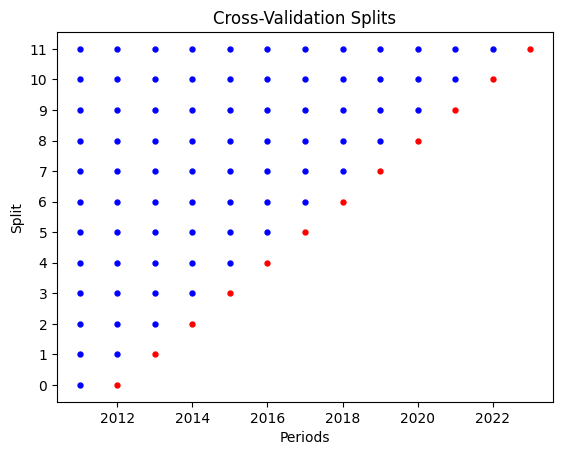

[IterativeImputer] Completing matrix with shape (539, 112)
[IterativeImputer] Ending imputation round 1/50, elapsed time 5.36
[IterativeImputer] Change: 57957416.80548044, scaled tolerance: 36239196.535000004 
[IterativeImputer] Ending imputation round 2/50, elapsed time 8.98
[IterativeImputer] Change: 6308097.769448407, scaled tolerance: 36239196.535000004 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (1078, 112)
[IterativeImputer] Ending imputation round 1/50, elapsed time 5.51
[IterativeImputer] Change: 57477680.559567615, scaled tolerance: 39731231.424 
[IterativeImputer] Ending imputation round 2/50, elapsed time 13.35
[IterativeImputer] Change: 10097238.5810641, scaled tolerance: 39731231.424 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (1617, 112)
[IterativeImputer] Ending imputation round 1/50, elapsed time 6.31
[IterativeImputer] Change: 53320599.29448492, scaled to

/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[IterativeImputer] Ending imputation round 1/50, elapsed time 13.27
[IterativeImputer] Change: 898898047.086547, scaled tolerance: 59638773.21104944 
[IterativeImputer] Ending imputation round 2/50, elapsed time 25.56
[IterativeImputer] Change: 1297855818.3070543, scaled tolerance: 59638773.21104944 
[IterativeImputer] Ending imputation round 3/50, elapsed time 37.70
[IterativeImputer] Change: 713946567.295353, scaled tolerance: 59638773.21104944 
[IterativeImputer] Ending imputation round 4/50, elapsed time 51.11
[IterativeImputer] Change: 760301840.63445, scaled tolerance: 59638773.21104944 
[IterativeImputer] Ending imputation round 5/50, elapsed time 64.63
[IterativeImputer] Change: 897037752.9997506, scaled tolerance: 59638773.21104944 
[IterativeImputer] Ending imputation round 6/50, elapsed time 80.80
[IterativeImputer] Change: 987703088.337585, scaled tolerance: 59638773.21104944 
[IterativeImputer] Ending imputation round 7/50, elapsed time 95.24
[IterativeImputer] Change: 105

/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[IterativeImputer] Ending imputation round 1/2, elapsed time 0.04
[IterativeImputer] Ending imputation round 2/2, elapsed time 0.07
[IterativeImputer] Completing matrix with shape (539, 112)
[IterativeImputer] Ending imputation round 1/3, elapsed time 0.03
[IterativeImputer] Ending imputation round 2/3, elapsed time 0.06
[IterativeImputer] Ending imputation round 3/3, elapsed time 0.09
[IterativeImputer] Completing matrix with shape (539, 112)
[IterativeImputer] Ending imputation round 1/3, elapsed time 0.03
[IterativeImputer] Ending imputation round 2/3, elapsed time 0.06
[IterativeImputer] Ending imputation round 3/3, elapsed time 0.09
[IterativeImputer] Completing matrix with shape (539, 112)
[IterativeImputer] Ending imputation round 1/3, elapsed time 0.02
[IterativeImputer] Ending imputation round 2/3, elapsed time 0.05
[IterativeImputer] Ending imputation round 3/3, elapsed time 0.07
[IterativeImputer] Completing matrix with shape (539, 112)
[IterativeImputer] Ending imputation r

In [191]:
# Encode Electoral Rating variable
encoder = OneHotEncoder()
encoder.fit(impute_Auxiliary_df[['Electoral Rating']])
encoded_categorical1 = encoder.transform(impute_Auxiliary_df[['Electoral Rating']])
# Convert encoded categorical variables to a DataFrame
encoded_df1 = pd.DataFrame(encoded_categorical1.toarray(), columns = encoder.get_feature_names_out(['Electoral Rating']))

# Encode Official Name State variable
encoder.fit(impute_Auxiliary_df[['Official Name State']])
encoded_categorical2 = encoder.transform(impute_Auxiliary_df[['Official Name State']])
# Convert encoded categorical variables to a DataFrame
encoded_df2 = pd.DataFrame(encoded_categorical2.toarray(), columns = encoder.get_feature_names_out(['Official Name State']))

# Join the encoded DataFrames with the original DataFrame
encoded_df = pd.concat([encoded_df1, encoded_df2], axis=1)

# combine with Auxiliary dataframe
impute_Auxiliary_df2 = impute_Auxiliary_df.join(encoded_df).copy()
impute_Auxiliary_df2 = impute_Auxiliary_df2.drop(columns = ['Electoral Rating','Official Name State'])

# Drop columns with missing values that do no present values in any of the cross validation folds
drop_vars = [66, 78, 79, 86, 87]
impute_Auxiliary_df2 = impute_Auxiliary_df2.drop(impute_Auxiliary_df2.columns[drop_vars], axis=1)

#set feature set as numeric values only
num_features = impute_Auxiliary_df2.select_dtypes(include=['int64', 'float64']).columns
# remove index from index list
num_features = num_features.drop('LGA_code')

#splits
n_cv_splits = (2023-2011)
# Specify panel split
panel_split = PanelSplit(periods = impute_Auxiliary_df2.Year, n_splits = n_cv_splits, gap = 0, test_size=1,plot=True)
# model instances
br_model = BayesianRidge(lambda_init = 1e-3, alpha_init = 1, max_iter = 1000)
#imputer
imputer_model = IterativeImputer(estimator = br_model,
                                 max_iter = 50,
                                 initial_strategy = 'median',
                                 imputation_order = 'ascending',
                                 tol = 1e-3,
                                 skip_complete=True,
                                 min_value=0,
                                 verbose = 3)
# fit and transform the data
impute_Auxiliary_df2[num_features], fitted_imputers = panel_split.cross_val_fit_transform(transformer = imputer_model,X = impute_Auxiliary_df2[num_features], include_test_in_fit=True)


In [193]:

# save to csv
impute_Auxiliary_df2.to_csv('impute_Auxiliary_df.csv', index = True)

# Imputation model Auxiliary Variables selection Algorithm - Quickpred
This Auxiliary variable selection strategy is similar to that proposed by van Buuren et al. (1999), but adopted for Cross-Sectional Time-Series (CSTS) Panel structure of the data.

parameters:
correlation threshold
top number of correlating candidate variables
candidate variable shortlist threshold
missingness threshold

1. Combine Analysis and Auxiliary variables.
2. Select the variables from Analysis set that have missing values, inclusive of Target variable.
3. For each of these Variables from step 2,
        a. For each year of the dataset,
            i. Compute correlation matrix and filter for variable, sort in descending order.
            ii. form candidate variable set based on correlation threshold or top number of variables.
  b. Determine frequency of candidate variable across all years, sort in descending order.
  c. Calculate Adjusted frequency of the candidate variable by the proportion of missingness according to $f' = \dfrac{f}{1-m}$, where ${m}$ is the proportion of missingness for the candidate variable and ${f}$ is the frequency of the variable.   
  d. If adjusted frequency $f'$ is greater than the shortlist threshold, then add candidate variable to shortlist.
4. Determine the union of all shortlist sets of candidate variables that correlate with Analytical Variables from step 2.
5. Sort the shortlist of candidate variables based on proportion of missingness, and select based on missingness threshold.

OUTPUT:Feature set of Auxiliary variables for imputation model

  

In [ ]:
# Auxiliary variable selection algorithm based on correlation
thresh_flag = True
# Number of top variables to consider for correlation
top_variable = 15
correlation_thresh = 0.4
# candidate selection threshold
thresh = 5
#missing theshold
missing_thresh = 0.35
#years of interest
years = range(2011,2024)
# filter from Analytical_df_year dataframe numerical variables only
combined_numerical_df =  impute_Auxiliary_df2.merge(Auxiliary_df, on = ['Year','LGA_name'],).select_dtypes(include=['int64', 'float64'])
Auxiliary_subset = {}
# return columns of dataframe with missing values and Target variable
missing_value_vars = list(Analytical_df.columns[Analytical_df.isnull().any()])
missing_value_vars.append('EV_prop')
for col1 in missing_value_vars:
  corr_dict = {}
  for year in years:
    combined_numerical_df_year = combined_numerical_df[combined_numerical_df['Year'] == year].copy()
    # Produce correlation matrix and sort values of EV_prop
    #select indices based on values being greater than a threshold
    correlations = abs(combined_numerical_df_year.corr()[col1]).sort_values(ascending = False)
    # Filter indices where correlation values are greater than the threshold
    if thresh_flag:
      filtered_indices = correlations[correlations > correlation_thresh].index
    else:
      filtered_indices = correlations.index[:top_variable]
    # Add the filtered indices to the dictionary
    corr_dict[year] = filtered_indices
  var_count = {}
  # for each year in the dictionary
  for col2 in combined_numerical_df.columns:
    for k,v in corr_dict.items():
      if col2 in v:
        if col2 in var_count:
          var_count[col2] += 1
        else:
          var_count[col2] = 1
  #sort dictionary by values
  var_count = {k: v for k, v in sorted(var_count.items(), key=lambda item: item[1], reverse=True)}
  # proportion of missingness
  missingness = combined_numerical_df.isnull().sum()/len(combined_numerical_df)
  # for each variable as key in dictionary
  for col3,v in var_count.items():
    #adjust value according to missingness
    value = v/(1-missingness.loc[col3])
    var_count[col3] = value
  #sort dictionary by values
  var_count = {k: v for k, v in sorted(var_count.items(), key=lambda item: item[1], reverse=True)}
  #If value is great than selection threshold, add key to a list
  var_list = []
  for k,v in var_count.items():
    if v > thresh:
      var_list.append(k)
  #if var_list not empty
  if var_list:
    var_list.remove(col1)
  #add Auxiliary and Analytical variable list to dictionary for the feature of interest.
  Auxiliary_subset[col1] = var_list
union_aux_subset = set()
intersect_aux_subset = set()
# for each key in Auxiliary_subset, find the union of all value lists
for k,v in Auxiliary_subset.items():
  union_aux_subset = union_aux_subset.union(set(v))
# Auxiliary variables to combine with Analysis variables
candidate_missing = missingness.loc[list(union_aux_subset)].sort_values()
selected_Aux_vars = candidate_missing[candidate_missing < missing_thresh].index
print(f'There are {len(selected_Aux_vars)} Auxiliary Variables.:')
# pickle the list of selected variables
with open('selected_Aux_vars.pickle', 'wb') as f:
    pickle.dump(list(selected_Aux_vars), f)
list(selected_Aux_vars)

### Bivariate plot of Auxiliary Variables with Analysis variables
1. For each Analysis variable, produce a pair plot with the subset of selected Auxiliary variables

In [ ]:
fig,axs = plt.subplots(3,4,figsize=(22, 18))
selected_Aux_vars1 = list(selected_Aux_vars)
selected_Aux_vars1.remove('Neighbourhood_EV_prop')
var_size = len(selected_Aux_vars1)
axs = axs.flatten()
Year = 2021
# filter for the year of interest
plot_df6 = Analytical_df.copy()
#calculate reciprocal distance to capital city
plot_df6['log_distance_capital'] = np.log(plot_df6['Distance_capital'])
# rearrange columns
cols = plot_df6.columns.tolist()
cols.append(cols.pop(cols.index('EV_prop')))
plot_df6 = plot_df6[cols]
#select numeric variables only
cat_vars = ['Official Name State','LGA_name']
mask = ~plot_df6.columns.isin(cat_vars)
# apply mask to columns of dataframe
plot_df6 = plot_df6[plot_df6.columns[mask]].copy()
count = 0
for col in plot_df6.columns[1:]:
    # filter for the year of interest
    plot_df6_combined = pd.concat([plot_df6['Year'],plot_df6[col],Auxiliary_df[selected_Aux_vars1]],axis = 1)
    # filter for the year of interest
    plot_df6_combined = plot_df6_combined[plot_df6_combined['Year'] == Year].drop(columns=['Year']).copy()
    # Create a correlation matrix
    ordered_corrs = abs(plot_df6_combined.corr()[col]).sort_values(ascending = False)
    corr_matrix = plot_df6_combined[ordered_corrs.index[:8]].corr()
    #create heatmap
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,cbar = count%4==0,ax = axs[count])
    # Add a title
    axs[count].set_title(f'Correlation Matrix Heatmap of Analysis Variables for year {Year}',size = 9)
    axs[count].set_xlabel(col, size=7)
    axs[count].set_ylabel(col, size=7)
    axs[count].tick_params(axis='both', which='major', labelsize=7)
    count +=1
plt.tight_layout()
#
plt.show()

### Save files

In [ ]:
Analytical_df.to_csv('Analysis_df.csv', index = True)
Auxiliary_df.to_csv('Auxiliary_df.csv', index = True)